## Description of the project

<b> Recovery of gold from ore.</b>

<b>Research purpose:</b>
Build a machine learning model that highlights the process of recovering gold from gold ore and calculate its efficiency.

<b>Research objectives:</b>
1. <a href = '#data'>Prepare</a> input data,
2. <a href = '#data_analysis'>Analyze</a> input data,
3. <a href='#model'> Modeling</a> data,
4. Calculate <a href = '#smape'>quality metric</a> ,
5. <a href = '#train_cv'>Train</a> different models using cross-validation,
6. Test the best model on <a href = '#test'>test</a> set,

<b> Initial data: </b>
    
Data:
    
- gold_recovery_train_new.csv - training sample,
- gold_recovery_test_new.csv - test sample,
- gold_recovery_full_new.csv - initial data;

Signs:
    
- Rougher feed - feedstock
- Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant
- Xanthate ** - xanthate (promoter, or flotation activator);
- Sulphate - sulfate (in this production, sodium sulfide);
- Depressant - depressant (sodium silicate).
- Rougher process (English "rough process") - flotation
- Rougher tails
- Float banks - flotation unit
- Cleaner process - cleaning
- Rougher Au - rough gold concentrate
- Final Au - final gold concentrate

Stage parameters:

- air amount — air volume
- fluid levels - fluid level
- feed size - feed granule size
- feed rate - feed rate

Stages:

- rougher - flotation
- primary_cleaner - primary cleaning
- secondary_cleaner - secondary cleaning
- final - final characteristics

Parameter types:

- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation - calculated characteristics

<a id = 'data'></a>
## Data preparation

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import preprocessing

In [139]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [140]:
display(f'Размер train выборки: {train.shape}')
display(f'Размер test выборки: {test.shape}')
display(f'Размер общей выборки: {full.shape}')

'Размер train выборки: (14149, 87)'

'Размер test выборки: (5290, 53)'

'Размер общей выборки: (19439, 87)'

### Train set

In [141]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [143]:
train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


### Test set

In [144]:
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [145]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [146]:
test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


### Full set

In [147]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [148]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [149]:
full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


### Enrichment efficiency

Let's calculate the enrichment efficiency on the training set for the feature rougher.output.recovery. Let's check the MAE metric between the calculated and actual values.

In [150]:
# объявление переменных
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

In [151]:
# RECOVERY высчитывает эффективность обогащения
RECOVERY = (C * (F - T)) * 100 / (F * (C - T))
RECOVERY = pd.Series(np.array(RECOVERY), index = RECOVERY.index)
display(f'Рассчитанная эффективность обогащения: {RECOVERY}')

'Рассчитанная эффективность обогащения: 0        87.107763\n1        86.843261\n2        86.842308\n3        87.226430\n4        86.688794\n           ...    \n14144    89.574376\n14145    87.724007\n14146    88.890579\n14147    89.858126\n14148    89.514960\nLength: 14149, dtype: float64'

The average sum of the absolute difference between the actual value - 'rougher.output.recovery' and the predicted value - 'RECOVERY'.

In [152]:
# MAE на обучающей выборке
print('MAE:', mean_absolute_error(train['rougher.output.recovery'], RECOVERY))

MAE: 1.1131451184435918e-14


The average sum of the difference between the values is close to 0, which means that the enrichment effect is calculated correctly.Средняя сумма разницы между значениями близка к 0, что означает, что эффектность обогащения рассчиатана правильно.

### Analysis of features, missing in test set

Let's analyze what features are missing in the test sample:

In [153]:
# разница в признаках обучающей выборки от тестовой
missing_test = train.columns.difference(test.columns)
missing_test

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

As expected, all of the final characteristics are missing from the test set, as data is collected at a later stage.
There is also no data with primary and secondary cleaning related to the numeric type, as well as other parameters.

### Data preprocessing

Let's preprocess the data: examine the number of missing values and duplicates.

In [154]:
train.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [155]:
train.isna().sum().sum()

4100

In [156]:
test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [157]:
test.isna().sum().sum()

90

Let's preprocess the data: examine the number of missing values and duplicates.

In [158]:
train = train.fillna(method = 'ffill')
test = test.fillna(method = 'ffill')

In [159]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [160]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


<a id = 'data_analysis'></a>
## Data Analysis

### Concentration of metals at different stages of purification

Let's consider how the concentration of metals (Au, Ag, Pb) changes at different stages of purification: roughing, primary purification and at the final stage.

In [161]:
AU = train[['final.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_au', 'rougher.input.feed_au']]
PB = train[['final.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'rougher.output.concentrate_pb', 'rougher.input.feed_pb']]
AG = train[['final.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'rougher.output.concentrate_ag', 'rougher.input.feed_ag']]    

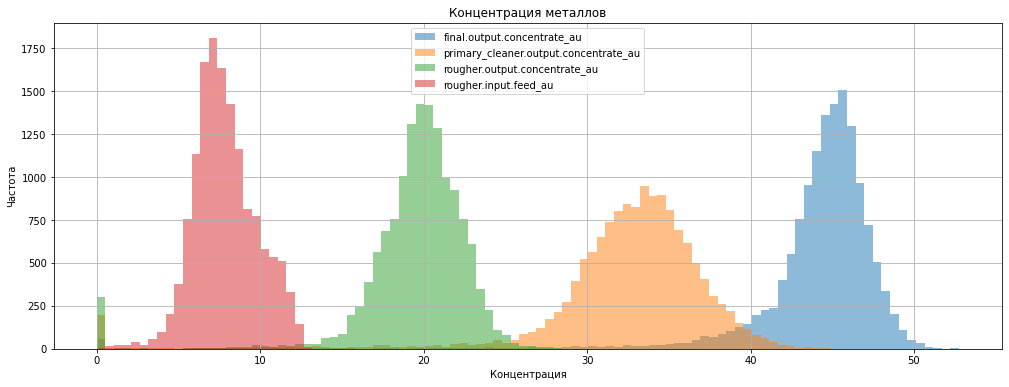

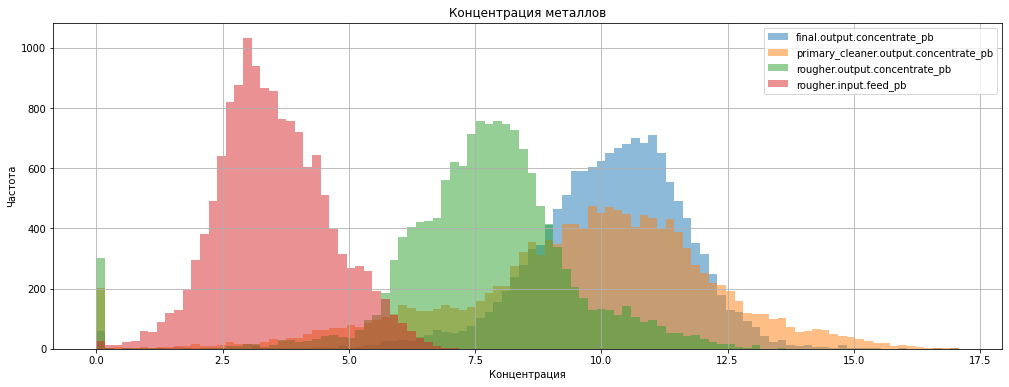

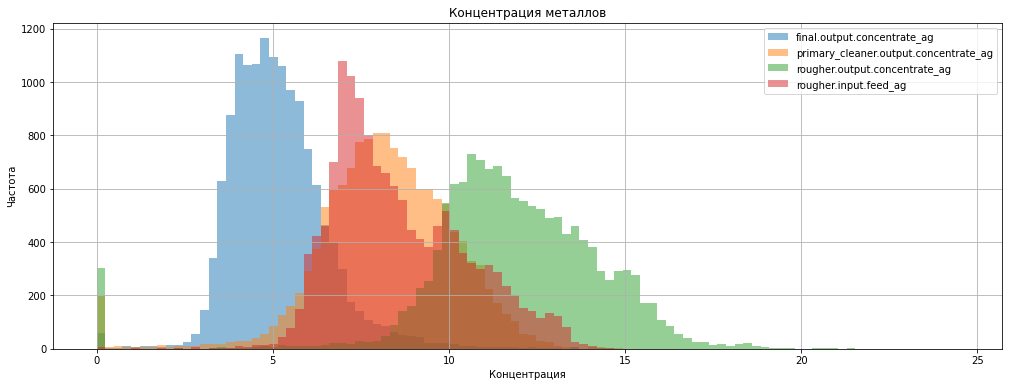

In [162]:
for i in [AU, PB, AG]:
    i.plot(
        kind = 'hist',
        grid = True,
        alpha = 0.5,
        figsize = (17, 6),
        title = 'Концентрация металлов',
        bins = 100
    ).set(
        xlabel = 'Концентрация',
        ylabel = 'Частота'
    )

- Au: stable - the concentration increases with the passage of cleaning: rough cleaning of raw materials -> rough -> after primary cleaning -> final,
- Pb: concentration at primary and final treatment is similar, roughing is lower,
- Ag: concentration is inversely proportional: decreases with the degree of purification: final -> primary cleaning -> roughing.

### Data distribution

Let us compare the size distributions of raw material granules on the training and test samples.

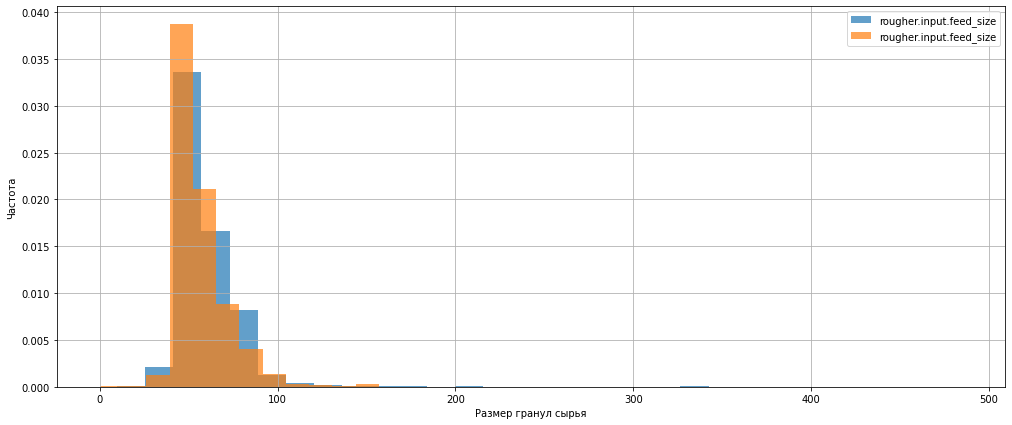

In [163]:
for i in [train['rougher.input.feed_size'], test['rougher.input.feed_size']]:
    i.hist(
        density = True,
        grid = True,
        bins = 30, 
        figsize = (17, 7),
        #title = 'Распределение размеров гранул сырья',
        alpha = 0.7,
        legend = True
    ).set(xlabel = 'Размер гранул сырья', ylabel = 'Частота')

Despite the fact that the size of the test sample is ~ 3 times smaller than the training sample, the distributions are similar (mean and quartiles).

In [164]:
train['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [165]:
test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

### Total concentration

We investigate the total concentration of all substances at different stages: in raw materials, in roughing and final concentrates.

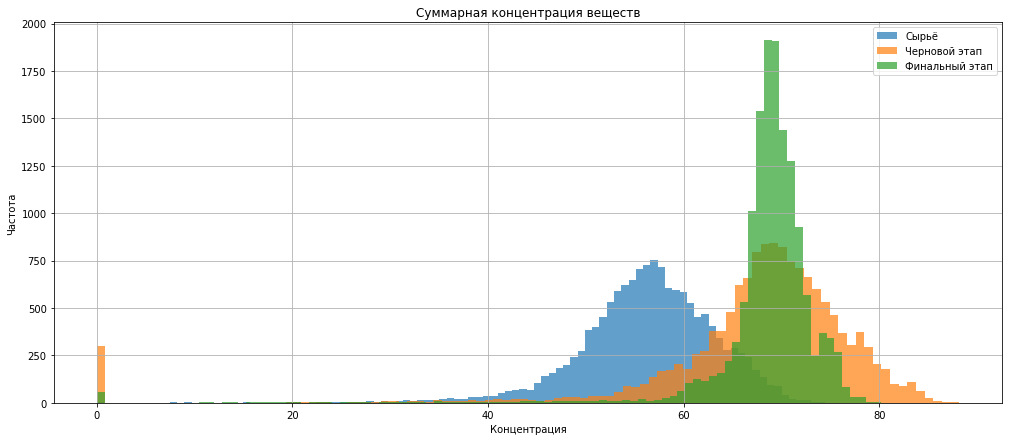

In [166]:
train[['rougher.input.feed_au', 
        'rougher.input.feed_pb', 
        'rougher.input.feed_ag',
        'rougher.input.feed_sol']]\
    .sum(axis = 1)\
    .plot(kind = 'hist', grid = True, legend = True, label ='Сырьё',  figsize = (17,7),
           alpha = 0.7, bins = 100)\
    .set(xlabel = 'Концентрация', ylabel = 'Частота')

train[['rougher.output.concentrate_au', 
        'rougher.output.concentrate_pb', 
        'rougher.output.concentrate_ag',
        'rougher.output.concentrate_sol']]\
    .sum(axis = 1)\
    .plot(kind = 'hist', grid = True, legend = True, label ='Черновой этап', figsize = (17,7),
           alpha = 0.7, bins = 100)\
    .set(xlabel = 'Концентрация', ylabel = 'Частота')

train[['final.output.concentrate_au', 
        'final.output.concentrate_pb', 
        'final.output.concentrate_ag',
        'final.output.concentrate_sol']]\
    .sum(axis = 1)\
    .plot(kind = 'hist', grid = True, legend = True, label ='Финальный этап', figsize = (17,7),
          title = 'Суммарная концентрация веществ', alpha = 0.7, bins = 100)\
    .set(xlabel = 'Концентрация', ylabel = 'Частота')

plt.show()

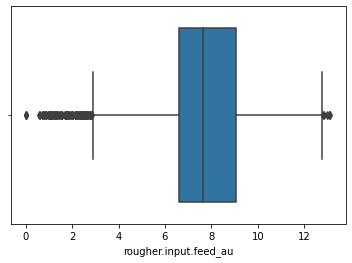

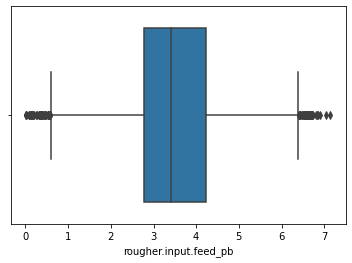

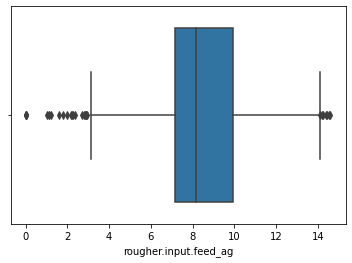

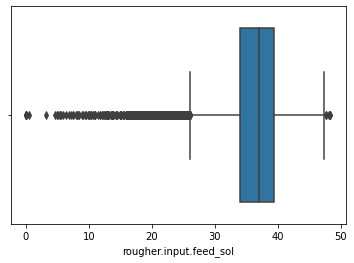

In [167]:
for metal in ['au', 'pb', 'ag', 'sol']:
    sns.boxplot(x = train['rougher.input.feed_{}'.format(metal)])
    plt.show()

- On average, the most common concentration coincides in the roughing and final stages,
- The concentration of substances in the raw material is lower than in the other stages,
- There are clear emissions at zero concentration that need to be eliminated.

From the range diagrams above, it can be noted that the emissions lie at concentrations < 0.5. Let's get rid of emissions.

In [168]:
for metal in ['au', 'pb', 'ag', 'sol']:
    train = train.loc[
                     (train['rougher.input.feed_{}'.format(metal)] >= 0.5) &
                     (train['rougher.output.concentrate_{}'.format(metal)] >= 0.5) &
                     (train['final.output.concentrate_{}'.format(metal)] >= 0.5)
                     ]

In [169]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13714 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                13714 non-null  object 
 1   final.output.concentrate_ag                         13714 non-null  float64
 2   final.output.concentrate_pb                         13714 non-null  float64
 3   final.output.concentrate_sol                        13714 non-null  float64
 4   final.output.concentrate_au                         13714 non-null  float64
 5   final.output.recovery                               13714 non-null  float64
 6   final.output.tail_ag                                13714 non-null  float64
 7   final.output.tail_pb                                13714 non-null  float64
 8   final.output.tail_sol                               13714 non-null  float64


In [170]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Diagram of the total concentration of substances after the removal of explicit emissions in near-zero concentration.

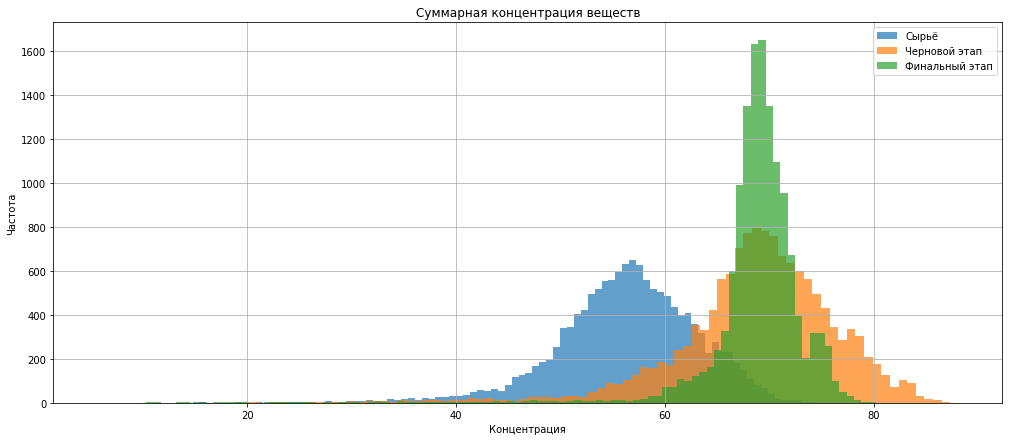

In [171]:
train[['rougher.input.feed_au', 
        'rougher.input.feed_pb', 
        'rougher.input.feed_ag',
        'rougher.input.feed_sol']]\
    .sum(axis = 1)\
    .plot(kind = 'hist', grid = True, legend = True, label ='Сырьё',  figsize = (17,7),
           alpha = 0.7, bins = 100)\
    .set(xlabel = 'Концентрация', ylabel = 'Частота')

train[['rougher.output.concentrate_au', 
        'rougher.output.concentrate_pb', 
        'rougher.output.concentrate_ag',
        'rougher.output.concentrate_sol']]\
    .sum(axis = 1)\
    .plot(kind = 'hist', grid = True, legend = True, label ='Черновой этап', figsize = (17,7),
           alpha = 0.7, bins = 100)\
    .set(xlabel = 'Концентрация', ylabel = 'Частота')

train[['final.output.concentrate_au', 
        'final.output.concentrate_pb', 
        'final.output.concentrate_ag',
        'final.output.concentrate_sol']]\
    .sum(axis = 1)\
    .plot(kind = 'hist', grid = True, legend = True, label ='Финальный этап', figsize = (17,7),
          title = 'Суммарная концентрация веществ', alpha = 0.7, bins = 100)\
    .set(xlabel = 'Концентрация', ylabel = 'Частота')

plt.show()

<a id = 'model'></a>
## Model training

<a id = 'smape'></a>
### Accuracy metrics

Accuarcy metrics sMAPE (Symmetric Mean Absolute Percentage Error):

$$ 
sMAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|)/2} * 100 
$$

In [174]:
def smape(actual, predicted):
    return (np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) / 2)).mean() * 100

In [175]:
def final_smape(actual_r, predicted_r, actual_f, predicted_f):
    return 0.25 * (smape(actual_r, predicted_r)) + 0.75 * (smape(actual_f, predicted_f))

<a id = 'train_cv'></a>
### Model Training and Cross Validation

Let us bring the training and test samples to the same type - to identical features. Let's add target features to the test set and get rid of the missing values in the test set in the training set.

In [176]:
# добавление целевых признаков
test = test.merge(full[['date', 'rougher.output.recovery', 'final.output.recovery']], on = 'date', how = 'left')
test.info()
# избавляемся от недостающих признаков
train = train.drop(missing_test, axis=1)
train = train.merge(full[['date', 'rougher.output.recovery', 'final.output.recovery']], on = 'date', how = 'left')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5290 non-null   float64
 2   primary_cleaner.input.depressant            5290 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [136]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13714 entries, 0 to 13713
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        13714 non-null  object 
 1   primary_cleaner.input.sulfate               13714 non-null  float64
 2   primary_cleaner.input.depressant            13714 non-null  float64
 3   primary_cleaner.input.feed_size             13714 non-null  float64
 4   primary_cleaner.input.xanthate              13714 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      13714 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    13714 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      13714 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    13714 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      13714 non-null  float64
 10  primary_cl

In [178]:
# разделяем выборки на признаки и целевые признаки
features_train_r = train.drop(train[['rougher.output.recovery','final.output.recovery', 'date']], axis = 1)
target_train_r = train[['rougher.output.recovery']]

features_train_f = train.drop(train[['rougher.output.recovery','final.output.recovery', 'date']], axis = 1)
target_train_f = train[['final.output.recovery']]

features_test_r = test.drop(test[['rougher.output.recovery','final.output.recovery', 'date']], axis = 1)
target_test_r = test[['rougher.output.recovery']]

features_test_f = test.drop(train[['rougher.output.recovery','final.output.recovery', 'date']], axis = 1)
target_test_f = test[['final.output.recovery']]

In [77]:
# Нормализация данных
scaler_rf = preprocessing.StandardScaler().fit(features_train_r)
scaler_ff = preprocessing.StandardScaler().fit(features_train_f)
scaler_rt = preprocessing.StandardScaler().fit(target_train_r)
scaler_ft = preprocessing.StandardScaler().fit(target_train_f)

features_train_R = scaler_rf.transform(features_train_r)
features_train_F = scaler_ff.transform(features_train_f)
target_train_R = scaler_rt.transform(target_train_r)
target_train_F = scaler_ft.transform(target_train_f)

In [179]:
print(features_train_r.shape, target_train_r.shape)
print(features_train_f.shape, target_train_f.shape)

(13714, 52) (13714, 1)
(13714, 52) (13714, 1)


In [180]:
# кастомизирование метрики
smape_score = make_scorer(smape, greater_is_better=False)

In [181]:
# Обучение моедли и подбор оптимальных гиперпараметров методом Grid Search
def scoring(new_model, params, f_train, t_train):
    
    grid_model = GridSearchCV(new_model, params,cv = 5, scoring = smape_score)
    grid_model.fit(f_train, t_train)
    
    display(f'Лучшие параметры: {grid_model.best_params_}')
    display(f'Значение sMAPE-меры: {grid_model.best_score_}')

In [182]:
features_train_r.isna().sum().sum()
target_train_r.isna().sum().sum()

0

In [183]:
train[['rougher.output.recovery']].isna().sum().sum()

0

#### Linear Regression

In [185]:
%%time

params_lr = {
    'n_jobs' : range(0, 10)
}


scoring(LinearRegression(), params_lr, features_train_r, target_train_r)
scoring(LinearRegression(), params_lr, features_train_f, target_train_f)

"Лучшие параметры: {'n_jobs': 0}"

'Значение sMAPE-меры: -7.2112579807448896'

"Лучшие параметры: {'n_jobs': 0}"

'Значение sMAPE-меры: -10.867431440438802'

CPU times: user 13.9 s, sys: 15.7 s, total: 29.6 s
Wall time: 29.5 s


As noted earlier, Feature standardization: features_train_R, target_train_R results in an sMAPE value of -30, while without scaler() an error of -7.2.

#### Random Forest Regressor

In [186]:
%%time

params_rfs = {
    'random_state' : [1],
    'n_estimators' : range(80, 140, 20),
    'max_depth' : range(1, 5)
}

scoring(RandomForestRegressor(), params_rfs, features_train_r, target_train_r.values.ravel())
scoring(RandomForestRegressor(), params_rfs, features_train_f, target_train_f.values.ravel())

"Лучшие параметры: {'max_depth': 4, 'n_estimators': 100, 'random_state': 1}"

'Значение sMAPE-меры: -6.851170901531775'

"Лучшие параметры: {'max_depth': 4, 'n_estimators': 120, 'random_state': 1}"

'Значение sMAPE-меры: -8.948627120686474'

CPU times: user 17min 25s, sys: 0 ns, total: 17min 25s
Wall time: 17min 25s


#### Decision Tree Regressor

In [187]:
%%time

params_dt = {
    'random_state' : [1],
    'max_depth' : range(1, 10),
    'min_samples_split' : range(2, 5),
    'min_samples_leaf' : range(1, 3)
}

scoring(DecisionTreeRegressor(), params_dt, features_train_r, target_train_r.values.ravel())
scoring(DecisionTreeRegressor(), params_dt, features_train_f, target_train_f.values.ravel())

"Лучшие параметры: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 1}"

'Значение sMAPE-меры: -7.2668600976707385'

"Лучшие параметры: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 1}"

'Значение sMAPE-меры: -9.314532885240682'

CPU times: user 2min 22s, sys: 0 ns, total: 2min 22s
Wall time: 2min 22s


<a id = 'test'></a>
### Model on a test set

The best values of the customized sMAPE metric for the Random Forest model. Let's test the model on a test set.

In [188]:
%%time

test_model_r = RandomForestRegressor(random_state = 1, max_depth = 4, n_estimators = 100)
test_model_f = RandomForestRegressor(random_state = 1, max_depth = 4, n_estimators = 100)
test_model_r.fit(features_train_r, target_train_r.values.ravel())
test_model_f.fit(features_train_f, target_train_f.values.ravel())
final_smape(target_train_r.values.ravel(), test_model_r.predict(features_train_r), 
            target_train_f.values.ravel(), test_model_f.predict(features_train_f))

CPU times: user 34.2 s, sys: 0 ns, total: 34.2 s
Wall time: 34.2 s


6.899760384863848

In order to evaluate the model, we can compare it with the Dummy Regressor model, which does not take into account the original data. That is, our task is to build a model that works better than a random model.

In [189]:
dummy_model_r = DummyRegressor()
dummy_model_f = DummyRegressor()
dummy_model_r.fit(features_train_r, target_train_r)
dummy_model_f.fit(features_train_f, target_train_f)

final_smape(target_train_r.values.ravel(), dummy_model_r.predict(features_train_r), 
            target_train_f.values.ravel(), dummy_model_f.predict(features_train_f))


9.437199995707104

The Random Forest Regressor model did the job, with a lower regression metric score than the random Dummy Regressor model.

## Conclusion

We have carried out work on forecasting the concentration of gold at the company "Numbers".

Having studied the data, pre-processed it and divided it into training, validation and test sets, we assessed how well 3 models understand the data:

1. Linear Regression - sMAPE metric indicator - 7.2% - the fastest model in training,
2. Random Forest Classifier - 6.8%,
3. Decision Tree Classifier - 7.3%.

We can <b>recommend</b> the <b>Random Forest Classifer</b> model for work, as it showed the highest accuracy and proved that it learns better than the random model on the test set.